# Identity Mining 

We will build identity mining tool for the corpus related to depression. 

## Dataset 

First we will start with the MyPersonality dataset with CES-D score. 

### Data cleaning

Let's clean the cesd_item_level.csv.   We will do 
* Arrange the answers according to the question numbers 
* Add the total score and verify with 939_userScores.csv 
* We will filter the data so that it contains only 939 data points, because other points contains invalid value.  

In the file “cesd_item_level.csv”, the scores are in the range [1,4], and questions 4, 8, 12 and 16 should be reverse-scored. This means that the CES-D scored should be computed as 

CES-D = (q1 - 1) + (q2 - 1) + (q3 - 1) + (4 - q4) + (q5 - 1) + …



In [2]:
import numpy as np
import pandas as pd

original = pd.read_csv('../project_materials/mypersonality_depression/cesd_item_level.csv', escapechar='\\')
cleanScore = pd.read_csv('../project_materials/mypersonality_depression/939_userScores.csv', escapechar='\\')

original_filtered = pd.DataFrame()


for i, row in cleanScore.iterrows():
    original_filtered = original_filtered.append( original[(original.userid == row.userid) & (original.time_completed == row.time_completed)]) 

original_filtered.shape


(939, 27)

In [3]:
original = original_filtered

original.question_order = original.question_order.apply(lambda x: np.fromstring(x, dtype=int, sep=","))

In [4]:
# %debug

for i in range(20):
    original['correctOrderQ' + str(i+1)] = 0

    
for i, row in original.iterrows():
    for index in range(row.question_order.shape[0]):
#         import ipdb; ipdb.set_trace()
        newOrder = 'correctOrderQ' + str(row.question_order[index])
        oldValue = 'q' + str(index + 1)
        original.loc[i,newOrder] = row[oldValue]
        



In [5]:
#Now we will get the CES-D score
original['score'] = 0
direction = [ 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1 ]
for index in range(1,21):
    dimName = 'correctOrderQ' + str(index)
    original.score = original.score + ( original[dimName] ) * direction[index-1]



### Data Exploration

Let's begin with the simple Histogram of scores.  

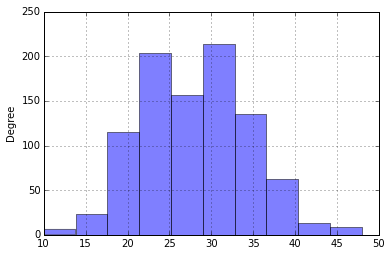

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
original.score.plot(kind='hist', alpha=0.5)

Now let's use gatherplot for interactive exploration.

https://gatherplot-dev.firebaseapp.com/#/ 



In [70]:
import dropbox
import re
import time
from firebase import firebase
from IPython.display import IFrame

def publish_gatherplot(p, dataname):
    
    filename = str(time.time())+'.csv'
    p.index.name = 'indexPandas'
    p.to_csv(filename)
    access_token = 'vwezSddRAD0AAAAAAAA0K2kAPqcpKnsShlfAPyIxSAYG0l2GxKfx5vtEkSyCeNOk'
    client = dropbox.client.DropboxClient(access_token)
    f = open(filename,'rb')
    response = client.put_file('./gatherplot/' + filename,f)
    print "uploaded:", response
    
    response = client.share('./gatherplot/' + filename, short_url=False)
    print 'Shared:', response
    url = response['url']
    match = re.search(r'https://www\.dropbox\.com/s/(.+)\?dl=0', url)
    if match:
#     print match.group(1)
        download_url = 'https://dl.dropboxusercontent.com/s/' + match.group(1)
        print download_url
        
    aFirebase = firebase.FirebaseApplication('https://gatherplot-dev.firebaseio.com',None)
    
    new_csv = {'name':dataname, 
           'uploader':"google:110953151430048855242", 
           'uploaderName': "Deok Gun Park",
           'url': download_url } 

    result = aFirebase.post('/csv',new_csv)
    print result
    

    return 'https://gatherplot-dev.firebaseapp.com/#/load/' + result['name']

In [71]:
# url = publish_gatherplot(original, "CES-D survey exploration - 939 filtered ")
url = u'https://gatherplot-dev.firebaseapp.com/#/load/-Jnisp3oVpf5W0h07lRP'

In [72]:
IFrame(url, 900,1200)

## Open IE 

We will analyze the result of Open IE. 

Open IE http://openie.allenai.org/
Open IE GitHub https://github.com/knowitall/openie

### Depressed Case 

We ran the reddit depressed.txt file and get the result.  


In [2]:
import pandas as pd
ieDepressed = pd.read_csv('../other_data/ie-depressed_trimmed.csv')


In [9]:
ieDepressed.head()
len(ieDepressed)

64213

The format is not so friendly to process.  Let's try human readable format.  
We ran the reddit depressed.txt and get the result as readable-ie-depressed.


In [30]:
import codecs
import re

f = codecs.open('../other_data/readable-ie-depressed.txt', 'rU', 'utf-8')

subject = []
relation = []
argument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        subject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        relation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        argument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [60]:
from nltk import *

lemmatizer = stem.WordNetLemmatizer()

lemaRelation = [ lemmatizer.lemmatize(word, pos='v') for phrase in relation for word in tokenize.word_tokenize(phrase)]

lemaRelationDist = FreqDist(lemaRelation)

relationDist = FreqDist(relation)
subjectDist = FreqDist(subject)
argumentDist = FreqDist(argument)

# relationDist.most_common(20)

for i,j in relationDist.most_common(20):
    print '* '  +  i




* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started


#### Lemmatization

I tried running lemmatization on the relationship data.  However the data was actually hard to get meaningful insight with lemmatization because it loses the the context like **don't know**.  You can see that **don't know** in the orginal data is replaced with **do** and **n't** in the lemmatized version. 

##### Top 20 words with lemmatization
* be
* to
* do
* n't
* have
* 'm
* want
* just
* get
* feel
* know
* 've
* 's
* try
* not
* go
* think
* can
* ca
* make



##### Top 20 words without lemmatization 

* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started

### Non Depressed Case 

Now I will do same for Non-depressed case.  First I will read the json file format. 

The raw data is too big in the sense it contains 800MB of text.   I will downsample it with 40MB of text which is 5% of total data.  

#### Segment original data into 400kb

In [16]:
import json
import codecs

numFiles = 100;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%2000 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)
        
# fSource.close()
# fDestination.close()
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


#### Run the open ie on the segmented data

In [2]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call
import os

numFiles = 100

os.chdir('/Users/intuinno/codegit/openie/')

os.getcwd()

numProcess = 4;

pool = Pool(numProcess)

commands = [ "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_materials/reddit/segNDepression" + str(i)  + ".txt ../cl2_final/project_materials/reddit/ie-segNDepression" + str(i)  + ".txt '" for i in range(numFiles)] 

for i, returncode in enumerate(pool.imap(partial(call, shell=True), commands)):
    print i
    print returncode
    if returncode != 0:
       print("%d command failed: %d" % (i, returncode))

0
0
1
0
2
0
3
1
3 command failed: 1
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0


#### Now combine this data into a single file again

In [11]:
#### Now combine this data into a single file again.  
import codecs

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

fDestination  = codecs.open('../project_materials/reddit/ie-NDepression.txt', mode = 'w', encoding='utf-8')

for num in range(numFiles):
    print num
    
    fSource = codecs.open('../project_materials/reddit/ie-segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

#     for i,line in enumerate(fSource):
    fDestination.write( fSource.read())
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Now Let's run the extraction of tuple for the Non depressed case


In [19]:
import codecs
import re

f = codecs.open('../other_data/ie-NDepression.txt', 'rU', 'utf-8')

NDsubject = []
NDrelation = []
NDargument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        NDsubject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        NDrelation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        NDargument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [21]:
import pandas as pd

NDtuple = pd.DataFrame({'subject':NDsubject, 'relation':NDrelation, 'argument':NDargument   })
NDtuple.to_csv('../other_data/NDtuples.csv', encoding='utf-8')

### Comparing KL divergence key contributors.  



In [67]:
from nltk import *

NDRelDist = FreqDist(NDrelation)
NDSubDist = FreqDist(NDsubject)
NDArguDist = FreqDist(NDargument)

NDRelDist.most_common(50)

NDRelDist['is']
print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))


    
    

0.0
1.24351816158e-05


In [52]:
klContributionRelDepressedToNonDepressed

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

### Now let's compare the words that is different from depressed and nondepressed people



In [53]:

print 'KL Divergence key contributor from depressed to nondepressed'
for i in range(30):
    print str(i) + '. ' + sorted_klDepressedToNonDepressed[i][0] 

KL Divergence key contributor from depressed to nondepressed
0. feel
1. 'm
2. do n't know
3. was
4. hate
5. am
6. do n't want
7. know
8. felt
9. just feel
10. to be
11. wish
12. feels
13. 've been
14. do n't know what to do to do
15. just want
16. do n't feel
17. to die
18. do
19. just need
20. told
21. 'm not
22. just wish
23. lost
24. try
25. started
26. wake up
27. to talk
28. had
29. do n't have


In [54]:
print 'KL Divergence key contributor from nondepressed to depressed'
for i in range(30):
    print str(i) + '. ' + sorted_klNonDepressedToDepressed[i][0] 

KL Divergence key contributor from nondepressed to depressed
0. is
1. are
2. has
3. 'm looking
4. was wondering
5. would like
6. would be
7. used
8. have
9. looks
10. 'd like
11. bought
12. will be
13. use
14. to play
15. to use
16. 're
17. looked
18. am looking
19. says
20. like
21. saw
22. included
23. run
24. play
25. looking
26. include
27. found
28. can get
29. plan


In [59]:
for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.002344969970

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | NonDepressed to Depressed | KLD score
------------ | ------------- | ------------ | -------------
feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.00234496997024 | am looking | 0.00186020227527
just need | 0.00232457533705 | says | 0.00162288714766
told | 0.00220530714892 | like | 0.00156547427076
'm not | 0.00220190139767 | saw | 0.00153061678674
just wish | 0.00219190453379 | included | 0.00151216917483
lost | 0.00209698332496 | run | 0.00148758905607
try | 0.00202329517571 | play | 0.00148171079383
started | 0.00197291885473 | looking | 0.00145494111641
wake up | 0.00184614958337 | include | 0.00144461132393
to talk | 0.00176865571138 | found | 0.00140188467898
had | 0.00173806268442 | can get | 0.0013639326444
do n't have | 0.00170597871196 | plan | 0.00127646126076


## The difference 'I' and 'me' usage pattern among the depressed people and nondepressed people.  



In [64]:
print subjectDist.freq('i')
print NDSubDist.freq('i')

0.549964961458
0.34516400597


In [68]:
print argumentDist.freq('me')
print NDArguDist.freq('me')

0.0298372654364
0.0148098605007


# LIWC Analysis

Now we will do LIWC analysis.  

## Build dictionary

I will build the category distribution of LIWC category.  To do that I will begin with liwc.dic file.  

From the liwc.dic file, I will extract the category and the words definition.  

* **liwc_def** : definition of category
* **liwc_words** : the words , and liwc category list tuple. 
* **getLIWC_Str** : get the string version of the liwc definition for words.  (ex: getLIWC_Str('abandons') returns ['affect', 'negemo', 'sad', 'cogmech', 'inhib'] 
* **getLIWC_Id** : get the numeric id version of the liwc definition for words. (ex: getLIWC_Id('affect') returns ['131', '133']

In [98]:

import pandas as pd
import re
import fnmatch


liwc_def = {}

for line in open('../other_data/liwc_defs.txt'):
    lineSplit = line.split()
    liwc_def[lineSplit[0]] = lineSplit[1]


liwc_words = []

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()
    liwc_words.append( (lineSplit[0],  lineSplit[1:len(lineSplit)] ) )

liwc_wordsExact = {}
liwc_wordsWild = {}

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()

    if lineSplit[0].endswith('*'):
        liwc_wordsWild[  lineSplit[0].rstrip('*') ] =   lineSplit[1:len(lineSplit)]
    else:
        liwc_wordsExact[lineSplit[0]] = lineSplit[1:len(lineSplit)]


def getLIWC_Id(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return catList

def getLIWC_Str(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return [liwc_def[catId] for  catId in catList ]

def getLIWC_IdFast(w):
        if w in liwc_wordsExact:
            # print w + ' : ' + str(catList)
            return liwc_wordsExact[w]
        else:
            for key, value in liwc_wordsWild.iteritems():
                if w.startswith(key):
                    return value



print getLIWC_Str('abandons')
print getLIWC_Id('affect')

print getLIWC_IdFast('abandons')
print getLIWC_IdFast('affect')



['affect', 'negemo', 'sad', 'cogmech', 'inhib']
['131', '133']
['125', '127', '130', '131', '137']
['131', '133']


### Let's run the code for the depressed case.  

In [99]:
import codecs
import re
from nltk import *

f = codecs.open('../project_materials/reddit/depressed.txt', 'rU', 'utf-8')

depressedAllText = word_tokenize(f.read())


liwcDist = FreqDist()



        

In [100]:
for (i,w) in enumerate(depressedAllText):
    wlower = w.lower()
    if i%10000 == 0:
        print i
    catList =  getLIWC_IdFast(wlower)
    if catList:
        for cat in catList:
            liwcDist[cat] += 1


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


In [101]:
liwcDist

FreqDist({'1': 263066, '2': 86637, '131': 84862, '11': 65150, '3': 60780, '250': 57242, '17': 53602, '4': 47228, '14': 38707, '12': 35839, ...})

## Now we will build a 80MB version of undepressed posts. 



In [74]:
import json
import codecs

numFiles = 1;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/nondepressed80MB' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%10 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)

0


In [103]:
import multiprocessing as mp

def liwcMPparse(num):
    print num

    f = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

    depressedAllText = word_tokenize(f.read())


    liwcDist = FreqDist()

    for (i,w) in enumerate(depressedAllText):
        wlower = w.lower()
        catList =  getLIWC_IdFast(wlower)
        if catList:
            for cat in catList:
                liwcDist[cat] += 1

    return liwcDist


pool = mp.Pool(processes=6)

result = pool.map(liwcMPparse, range(100))

liwcNDDist = reduce(lambda x, y: x+y, result)


5
15
0
10
20
25
6161112126





7172122227





8183132328





9194142429





305055354540





315156364641





325257374742





335358384843





345459394944





607585658070





617686668171





627787678272





637888688373





647989698474





9590

9691

9792

9893

9994



KeyboardInterrupt: 

In [105]:
import pickle

output = open('liwcNDDist.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcNDDist = pickle.load(output)

output.close()

In [120]:
depressedProbDist = LaplaceProbDist( liwcDist )
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcNDDist))

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcDist.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcNDDist.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) 
    

i | 0.0297223407593 | article | 0.0188451679091
ppron | 0.0200478226323 | funct | 0.0121146129348
pronoun | 0.0190746365626 | preps | 0.0118820307886
negemo | 0.0115120514733 | space | 0.00972325748048
sad | 0.00819327062349 | relativ | 0.00943656745716
affect | 0.00677807591567 | money | 0.00603035430839
health | 0.00474421769244 | leisure | 0.00583158380293
bio | 0.00363245390444 | social | 0.00489509464607
past | 0.00344426103127 | tentat | 0.00442704103531
adverb | 0.0030219613743 | you | 0.00435462688474
feel | 0.00290326564529 | see | 0.00415504982348
verb | 0.00262749086973 | quant | 0.00373701288603
anx | 0.00247461716498 | achieve | 0.00343759263368
insight | 0.0024269920569 | incl | 0.00316966835962
family | 0.0021878415283 | work | 0.0030210406991
time | 0.00206420288525 | posemo | 0.00262936828665
present | 0.001796323292 | future | 0.00253504445006
negate | 0.00145195699011 | auxverb | 0.0025211185846
friend | 0.00144378097066 | we | 0.00245000031214
certain | 0.0013225553

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | NonDepressed to Depressed | KLD score
----------------|---------|-------------|----------------
i | 0.0297223407593 | article | 0.0188451679091
ppron | 0.0200478226323 | funct | 0.0121146129348
pronoun | 0.0190746365626 | preps | 0.0118820307886
negemo | 0.0115120514733 | space | 0.00972325748048
sad | 0.00819327062349 | relativ | 0.00943656745716
affect | 0.00677807591567 | money | 0.00603035430839
health | 0.00474421769244 | leisure | 0.00583158380293
bio | 0.00363245390444 | social | 0.00489509464607
past | 0.00344426103127 | tentat | 0.00442704103531
adverb | 0.0030219613743 | you | 0.00435462688474
feel | 0.00290326564529 | see | 0.00415504982348
verb | 0.00262749086973 | quant | 0.00373701288603
anx | 0.00247461716498 | achieve | 0.00343759263368
insight | 0.0024269920569 | incl | 0.00316966835962
family | 0.0021878415283 | work | 0.0030210406991
time | 0.00206420288525 | posemo | 0.00262936828665
present | 0.001796323292 | future | 0.00253504445006
negate | 0.00145195699011 | auxverb | 0.0025211185846
friend | 0.00144378097066 | we | 0.00245000031214
certain | 0.00132255539141 | cogmech | 0.00217265965231
anger | 0.00113611303231 | motion | 0.00198018212719
swear | 0.000941253493055 | conj | 0.00166383895428
death | 0.00078745052477 | number | 0.00158569006813
filler | 0.000763096871914 | percept | 0.00141067668628
excl | 0.000572189786165 | discrep | 0.00133501658561
sexual | 0.000453606382195 | inhib | 0.000834263117877
shehe | 0.00023569904543 | relig | 0.000743072070393
home | 0.000138698325475 | they | 0.000728530190696
humans | 6.94670700563e-05 | cause | 0.000579561156327
ipron | -4.71619196513e-05 | ingest | 0.000464977399827

In [116]:
liwcNDDist


Counter({'1': 3669386, '131': 1163550, '2': 954230, '250': 873508, '17': 849720, '11': 842617, '3': 606969, '121': 525939, '12': 509849, '14': 497911, '18': 448738, '10': 439180, '252': 399287, '4': 360932, '125': 356788, '9': 347261, '253': 327797, '16': 323682, '138': 320390, '126': 236701, '135': 234737, '20': 216393, '139': 211155, '13': 205935, '132': 157729, '140': 143026, '134': 132202, '355': 131522, '354': 130493, '251': 120107, '127': 117120, '133': 114532, '146': 101720, '356': 95403, '136': 83463, '7': 81477, '6': 77403, '358': 66781, '19': 64321, '15': 63980, '141': 61578, '21': 51988, '8': 44662, '129': 44250, '5': 42495, '124': 42254, '143': 38722, '147': 37639, '137': 35302, '142': 31609, '148': 30184, '464': 26143, '357': 24829, '130': 22603, '150': 21959, '149': 17893, '128': 17210, '122': 14382, '123': 13897, '359': 12635, '22': 11888, '360': 11625, '462': 10910, '463': 7774})